In [1]:
%pip install -q langgraph langchain_google_genai langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [3]:
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash")

#Messages as state

In [5]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [6]:
llm.invoke(messages)

AIMessage(content="That's great you're interested in ocean mammals!  Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest other groups to research, I need a little more context. What aspects of whales interest you?  Knowing that will help me tailor suggestions.\n\nFor example, are you interested in:\n\n* **Specific behaviors?** (e.g., communication, migration, hunting strategies)  If so, I can suggest other mammals that exhibit similar or contrasting behaviors.\n* **Specific habitats?** (e.g., deep sea, coastal areas, polar regions)  Different mammals are adapted to different environments.\n* **Evolutionary relationships?**  Understanding the evolutionary history of marine mammals is fascinating.\n* **Conservation status?** Many marine mammals are endangered or threatened.\n\nHowever, here are some groups of ocean mammals you should definitely learn about, regardless of your specific interests:\n\n* **Dolphins and Porpoises:**  These highly intelligen

#Simple graph with MessagesState

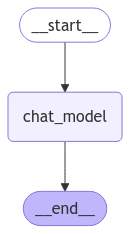

In [7]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image, display

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({"messages": messages})

for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  Beyond whales, the world of ocean mammals is incredibly diverse. To suggest further research, let's break it down by group:

**1. Pinnipeds (fin-footed mammals):** This group includes seals, sea lions, and walruses.  Each has distinct characteristics:

* **Seals:**  Generally lack external ear flaps (pinnae), have streamlined bodies for efficient swimming, and often haul out on land or ice.  There are many species with varied adaptations.
* **Sea Lions:** Possess external ear flaps, are generally larger than seals, and are known for their agility on land.
* **Walruses:**

#Streaming the events from llm

In [9]:
async for m in graph.astream_events({"messages": messages}, version="v2"):
      print(m)
      print("\n--------------------------------------------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='17740c52-9cda-4857-85af-11b5b684c265'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='8a4c71d3-2b8b-4054-99e3-fe945f94f8d4')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '970dd8dd-4f28-4dde-8446-5f0935e4e353', 'metadata': {}, 'parent_ids': []}

--------------------------------------------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='17740c52-9cda-4857-85af-11b5b684c265'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='8a4c71d3-2b8b-4054-99e3-fe945

##Using RemoveMessage modifier and add_messages reducer to manage long running conversation

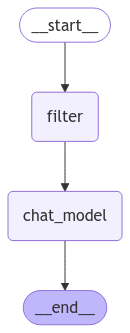

In [10]:
from langchain_core.messages import RemoveMessage
from typing import Dict

def filter_messages(state: MessagesState):
    delete_messages = []
    for m in state["messages"][:-2]:
      delete_messages.append(RemoveMessage(id=m.id))
    print(delete_messages)
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fascinating group, but there's a whole world beyond them.  To suggest other ocean mammals for your research, it would help to know what aspects of whales interest you.  For example, are you interested in:

* **Their behavior?** (e.g., social structures, hunting techniques, communication)
* **Their biology?** (e.g., anatomy, physiology, reproduction)
* **Their conservation status?** (e.g., threats

#Filtering message by passing last message of list to llm

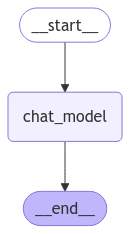

In [12]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fascinating group, but there's a whole world beyond them.  To suggest other ocean mammals for your research, it would help to know what aspects of whales interest you.  For example, are you interested in:

* **Their behavior?** (e.g., social structures, hunting techniques, communication)
* **Their biology?** (e.g., anatomy, physiology, reproduction)
* **Their co

In [14]:
output = graph.invoke({"messages": messages})

for msg in output["messages"]:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fascinating group, but there's a whole world beyond them.  To suggest other ocean mammals for your research, it would help to know what aspects of whales interest you.  For example, are you interested in:

* **Their behavior?** (e.g., social structures, hunting techniques, communication)
* **Their biology?** (e.g., anatomy, physiology, reproduction)
* **Their co

#Trim messages

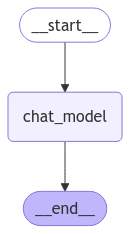

In [23]:
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState) -> MessagesState:
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("Tell me where Orcas live!", name="Lance"))

In [25]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash"),
            allow_partial=False
            )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [26]:
graph.invoke({"messages": messages})

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content="That's great you're interested in ocean mammals! Whales are a fascinating group, but there's a whole world beyond them.  To suggest other ocean mammals for your research, it would help to know what aspects of whales interest you.  For example, are you interested in:\n\n* **Their behavior?** (e.g., social structures, hunting techniques, communication)\n* **Their biology?** (e.g., anatomy, physiology, reproduction)\n* **Their conservation status?** (e.g., threats, population sizes, 